In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import re
import nltk
import contractions
from plotmat import plot_mat
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from sklearn import svm
from sklearn import datasets, metrics
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix
import umap


from sklearn.metrics.cluster import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import AgglomerativeClustering




In [2]:
import hdbscan

In [3]:
from tempfile import mkdtemp


In [4]:
cachedir = mkdtemp()


In [5]:
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r'http\S+', '', text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    texter = texter.strip()
    texter = contractions.fix(texter)
    texter = re.sub('''[!"#$%&'()*+,/;:-<=>?@[\]^_`{|}~-]''', '', texter)
    texter = texter.lower()
    texter = re.sub(' +', ' ', texter)
    if texter == "":
        texter = ""
    return texter

In [6]:
# Function to get POS Tag
def get_pos_tags(nltkTag):
    firstChar = nltkTag[0]
    if firstChar == 'J':
        return wordnet.ADJ
    if firstChar == 'S':
        return wordnet.ADJ_SAT
    if firstChar == 'V':
        return wordnet.VERB
    if firstChar == 'N':
        return wordnet.NOUN
    if firstChar == 'R':
        return wordnet.ADV
    return wordnet.NOU

In [7]:
#removing stop words
def remove_stopwords(words,stop_words):
    return " ".join([word for word in words if word not in stop_words])

In [8]:
# Whole preprocessing pipeline with removing stop words
def preprocess(sample):
    sample = clean(sample)
    sample = sample.split('.')
    sample = [remove_stopwords(nltk.word_tokenize(sentence), stop_words) for sentence in sample]
    sample = '.'.join(sample)
    return sample

In [9]:
"""
Functions to get the trained SVD and NMF model
"""

def getSVD(n_comp, data):
    SVD = TruncatedSVD(n_components=n_comp, random_state=42)
    SVD.fit(data)
    return SVD

# NMF Non-negative Matrix Factorization
def getNMF(n_comp, data):
    NMFmodel = NMF(n_components=n_comp, init='random', random_state=42)
    NMFmodel.fit(data)
    return NMFmodel

In [10]:
def getScores(y_true, y_pred):

    Homogeneity = homogeneity_score(y_true, y_pred)
    Completeness = completeness_score(y_true, y_pred)
    V_measure = v_measure_score(y_true, y_pred)
    AdjustedRandIndex = adjusted_rand_score(y_true, y_pred)
    Adjusted_mutual_information_score = adjusted_mutual_info_score(y_true, y_pred)
    return {
        'Homogeneity': Homogeneity,
        'Completeness': Completeness,
        'V_measure': V_measure,
        'AdjustedRandIndex': AdjustedRandIndex,
        'Adjusted_mutual_information_score': Adjusted_mutual_information_score
    }

In [11]:
news_data = datasets.fetch_20newsgroups(subset='all', remove=('headers', 'footers'))
labels = np.array(news_data.target)

In [12]:
# Initializations
stop_words = set(stopwords.words('English'))

In [13]:
featurePipeline = Pipeline([
    ('count', CountVectorizer(preprocessor=preprocess, stop_words='english', min_df=3)),
    ('tfidf', TfidfTransformer(smooth_idf=True, use_idf=True))
]).fit(news_data.data)


In [14]:
tfidf_features = featurePipeline.transform(news_data.data)

In [15]:
print(" Data TF-IDF Matrix size: {}".format(tfidf_features.shape))

 Data TF-IDF Matrix size: (18846, 43025)


## Using SVD

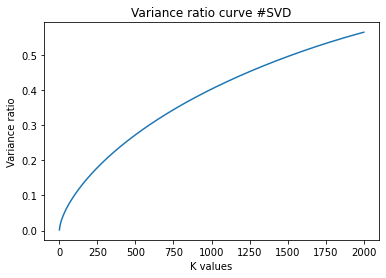

In [15]:
n_components = 2000
SVD = getSVD(n_components, tfidf_features)
variance_ratio = SVD.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(variance_ratio)


plt.plot(np.arange(n_components) + 1, cumulative_variance_ratio)
plt.xlabel("K values")
plt.ylabel("Variance ratio")
plt.title("Variance ratio curve #SVD")
plt.show()

In [19]:
r = [1,2,3,5,10,20,50,100,300, 500, 1000]

SVDScores_Homogeneity = []
SVDScores_Completeness = []
SVDScores_V_measure = []
SVDScores_AdjustedRandIndex = []
SVDScores_Adjusted_mutual_information_score = []


for k in r:
    SVD = getSVD(k, tfidf_features)
    transformed = SVD.transform(tfidf_features)
    kmeans = KMeans(n_clusters=20, random_state=0, max_iter=3000, n_init=50).fit(transformed)
    predictedLabels = kmeans.labels_
    scores = getScores(labels, predictedLabels)
    SVDScores_Homogeneity.append(scores['Homogeneity'])
    SVDScores_Completeness.append(scores['Completeness'])
    SVDScores_V_measure.append(scores['V_measure'])
    SVDScores_AdjustedRandIndex.append(scores['AdjustedRandIndex'])
    SVDScores_Adjusted_mutual_information_score.append(scores['Adjusted_mutual_information_score'])

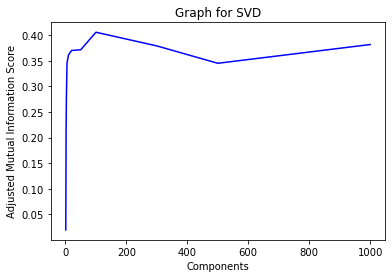

In [20]:
plt.plot(r, SVDScores_Adjusted_mutual_information_score, color='b')
  
plt.xlabel("Components")
plt.ylabel("Adjusted Mutual Information Score")
plt.title("Graph for SVD")
  
plt.show()

In [21]:
r[np.argmax(SVDScores_Adjusted_mutual_information_score)]

100

In [22]:
SVDScores_Adjusted_mutual_information_score[6]

0.37130579202183484

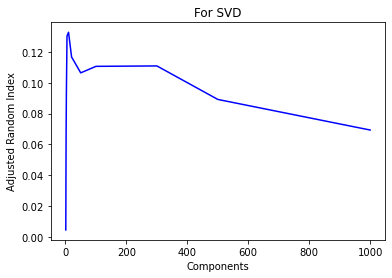

In [23]:
plt.plot(r, SVDScores_AdjustedRandIndex, color='b')
  
plt.xlabel("Components")
plt.ylabel("Adjusted Random Index")
plt.title("For SVD")
  
plt.show()

In [27]:
r[np.argmin(SVDScores_AdjustedRandIndex[1:])]

1

In [1]:
n_components = 1000

SVD = getSVD(n_components, tfidf_features)
transformed_features = SVD.transform(tfidf_features)

kmeans = KMeans(n_clusters=20, random_state=0, max_iter=5000, n_init=50).fit(transformed_features)
predicted_labels = kmeans.labels_

scores = getScores(labels, predicted_labels)

NameError: name 'getSVD' is not defined

In [23]:
scores

{'Homogeneity': 0.3657407059348793,
 'Completeness': 0.4604235535487772,
 'V_measure': 0.4076565490964736,
 'AdjustedRandIndex': 0.1106090872261982,
 'Adjusted_mutual_information_score': 0.405508118880332}

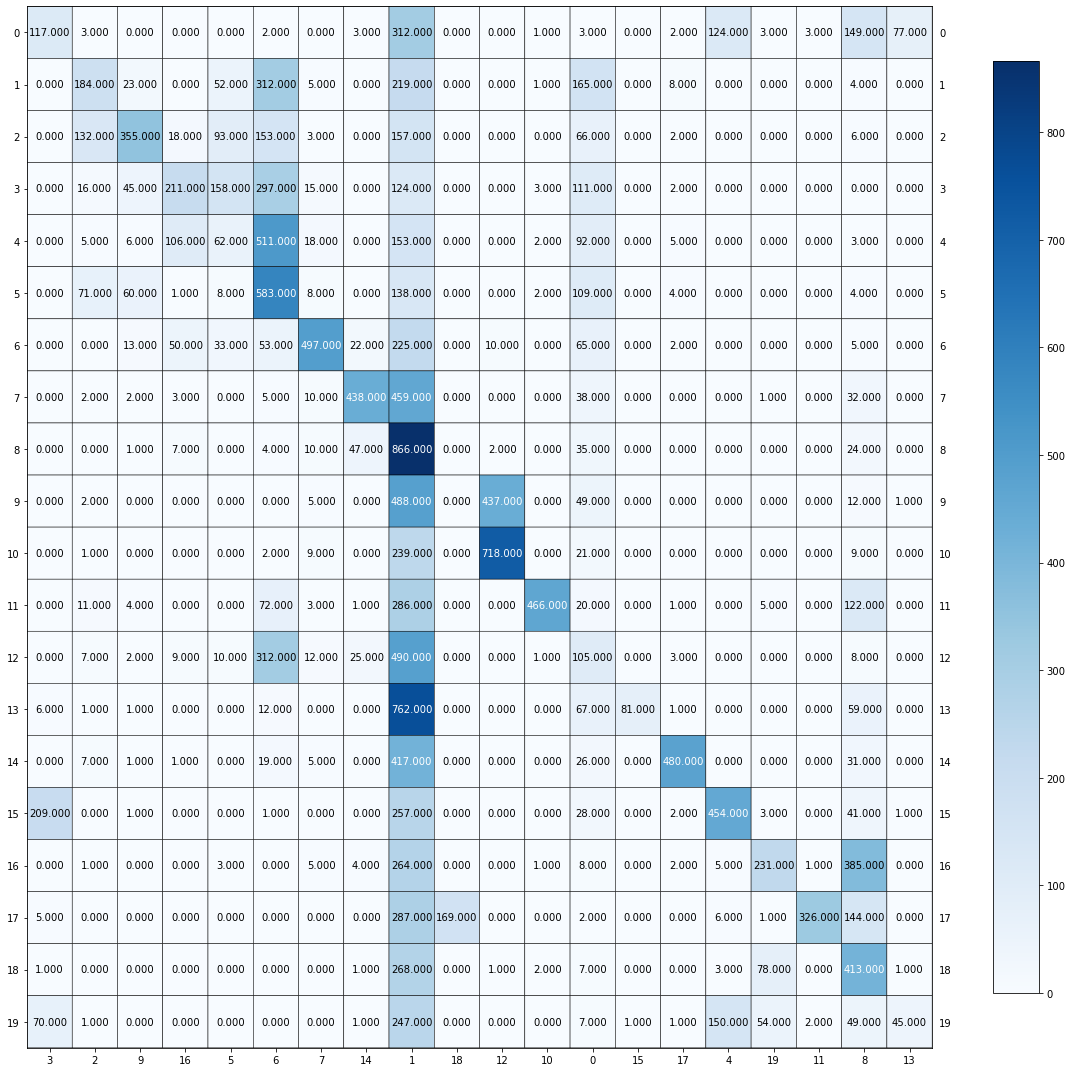

In [24]:
conf_mat = confusion_matrix(labels, predicted_labels)
row, colmn = linear_sum_assignment(conf_mat, maximize=True)
plot_mat(conf_mat[row[:, np.newaxis], colmn], xticklabels=colmn, yticklabels=row, size=(15,15))


## Using NMF

In [28]:
r = [1,5,10,50,100,300]
NMFScores_Homogeneity = []
NMFScores_Completeness = []
NMFScores_V_measure = []
NMFScores_AdjustedRandIndex = []
NMFScores_Adjusted_mutual_information_score = []

for k in r:
    NMFmodel = getNMF(k, tfidf_features)
    transformed = NMFmodel.transform(tfidf_features)
    kmeans = KMeans(n_clusters=20, random_state=0, max_iter=3000, n_init=50).fit(transformed)
    predictedLabels = kmeans.labels_
    scores = getScores(labels, predictedLabels)
    NMFScores_Homogeneity.append(scores['Homogeneity'])
    NMFScores_Completeness.append(scores['Completeness'])
    NMFScores_V_measure.append(scores['V_measure'])
    NMFScores_AdjustedRandIndex.append(scores['AdjustedRandIndex'])
    NMFScores_Adjusted_mutual_information_score.append(scores['Adjusted_mutual_information_score'])


/Users/diplavsrivastava/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/Users/diplavsrivastava/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/Users/diplavsrivastava/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


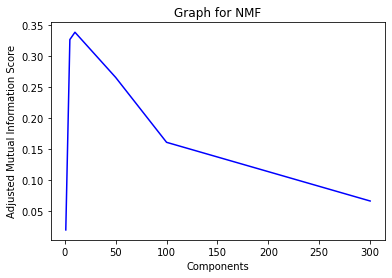

In [29]:
plt.plot(r, NMFScores_Adjusted_mutual_information_score, color='b')
  
plt.xlabel("Components")
plt.ylabel("Adjusted Mutual Information Score")
plt.title("Graph for NMF")
  
plt.show()

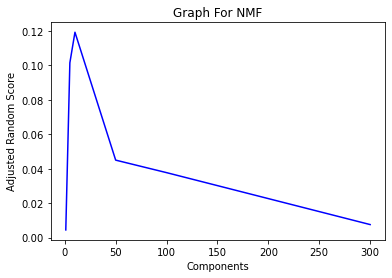

In [30]:
plt.plot(r, NMFScores_AdjustedRandIndex, color='b')
  
plt.xlabel("Components")
plt.ylabel("Adjusted Random Score")
plt.title("Graph For NMF")
  
plt.show()

In [31]:
n_components = 10


NMFmodel = getNMF(n_components, tfidf_features)
transformed_features = NMFmodel.transform(tfidf_features)

kmeans = KMeans(n_clusters=20, random_state=0, max_iter=5000, n_init=50).fit(transformed_features)
predicted_labels_NMF = kmeans.labels_

scores = getScores(labels, predicted_labels_NMF)

In [32]:
scores

{'Homogeneity': 0.32117310066123195,
 'Completeness': 0.36156795498805255,
 'V_measure': 0.34017553285357427,
 'AdjustedRandIndex': 0.11921399244656643,
 'Adjusted_mutual_information_score': 0.33790744391494965}

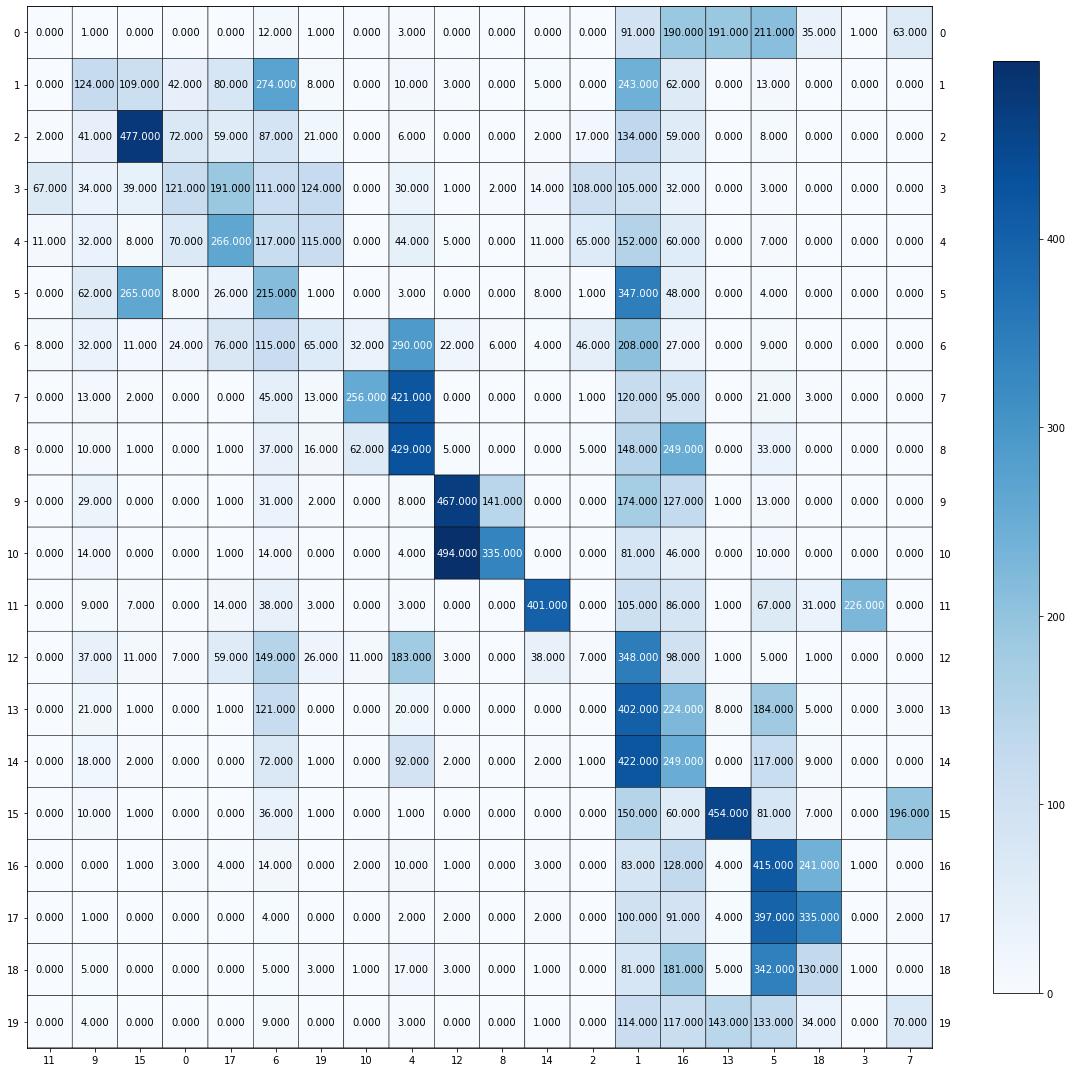

In [33]:
conf_mat = confusion_matrix(labels, predicted_labels_NMF)
row, colmn = linear_sum_assignment(conf_mat, maximize=True)
plot_mat(conf_mat[row[:, np.newaxis], colmn], xticklabels=colmn, yticklabels=row, size=(15,15))


## UMAP

In [34]:
n_comps = [5, 20, 200]

### Euclidean 

In [35]:
UMAP_Eucl_Homogeneity = []
UMAP_Eucl_Completeness = []
UMAP_Eucl_V_measure = []
UMAP_Eucl_AdjustedRandIndex = []
UMAP_Eucl_Adjusted_mutual_information_score = []
UMAP_Eucl_predlabels = []

for k in n_comps:
    umap_fit = umap.UMAP(n_components=k, random_state=0, metric='euclidean')
    umap_features = umap_fit.fit_transform(tfidf_features)
    kmeans = KMeans(n_clusters=20, random_state=0, max_iter=5000, n_init=50).fit(umap_features)
    predicted_labels = kmeans.labels_
    scores = getScores(labels, predicted_labels)
    UMAP_Eucl_predlabels.append(predicted_labels)
    UMAP_Eucl_Homogeneity.append(scores['Homogeneity'])
    UMAP_Eucl_Completeness.append(scores['Completeness'])
    UMAP_Eucl_V_measure.append(scores['V_measure'])
    UMAP_Eucl_AdjustedRandIndex.append(scores['AdjustedRandIndex'])
    UMAP_Eucl_Adjusted_mutual_information_score.append(scores['Adjusted_mutual_information_score'])


In [36]:
Umap_Cosine_Scores = np.vstack([n_comps,UMAP_Eucl_Homogeneity, UMAP_Eucl_Completeness, UMAP_Eucl_V_measure, UMAP_Eucl_AdjustedRandIndex, UMAP_Eucl_Adjusted_mutual_information_score])
Umap_Cosine_Scores = Umap_Cosine_Scores.T

print("Scores for Umap with Euclidean")
pd.DataFrame(Umap_Cosine_Scores, columns=['Num of Components','Homogeneity', 'Completeness', 'Vmeasure', 'ARI', 'AMIS'])

Scores for Umap with Euclidean


,Num of Components,Homogeneity,Completeness,Vmeasure,ARI,AMIS
0,5.0,0.005090,0.005111,0.005101,0.000662,0.001884
1,20.0,0.004786,0.004808,0.004797,0.000553,0.001578
2,200.0,0.005313,0.005532,0.005420,0.000662,0.002144


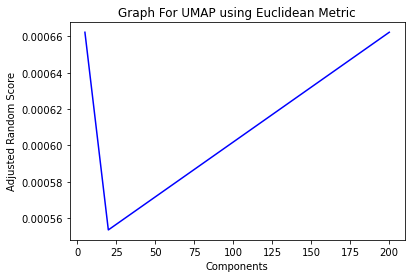

In [37]:
plt.plot(n_comps, UMAP_Eucl_AdjustedRandIndex, color='b')
  
plt.xlabel("Components")
plt.ylabel("Adjusted Random Score")
plt.title("Graph For UMAP using Euclidean Metric")
  
plt.show()

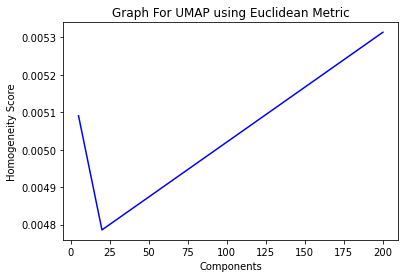

In [38]:
plt.plot(n_comps, UMAP_Eucl_Homogeneity, color='b')
  
plt.xlabel("Components")
plt.ylabel("Homogeneity Score")
plt.title("Graph For UMAP using Euclidean Metric")
  
plt.show()

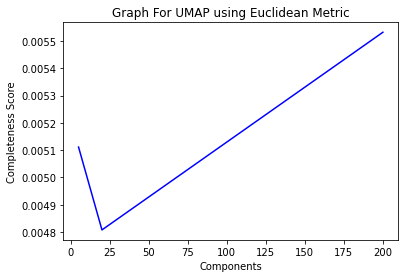

In [39]:
plt.plot(n_comps, UMAP_Eucl_Completeness, color='b')
  
plt.xlabel("Components")
plt.ylabel("Completeness Score")
plt.title("Graph For UMAP using Euclidean Metric")
  
plt.show()

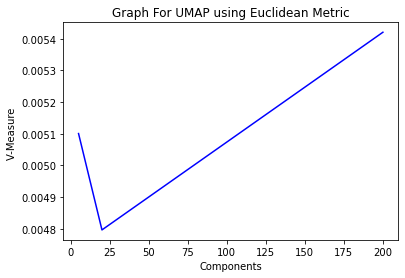

In [40]:
plt.plot(n_comps, UMAP_Eucl_V_measure, color='b')
  
plt.xlabel("Components")
plt.ylabel("V-Measure ")
plt.title("Graph For UMAP using Euclidean Metric")
  
plt.show()

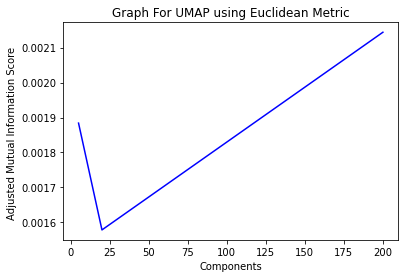

In [41]:
plt.plot(n_comps, UMAP_Eucl_Adjusted_mutual_information_score, color='b')
  
plt.xlabel("Components")
plt.ylabel("Adjusted Mutual Information Score ")
plt.title("Graph For UMAP using Euclidean Metric")
  
plt.show()

#### confusion matric for #comp = 5

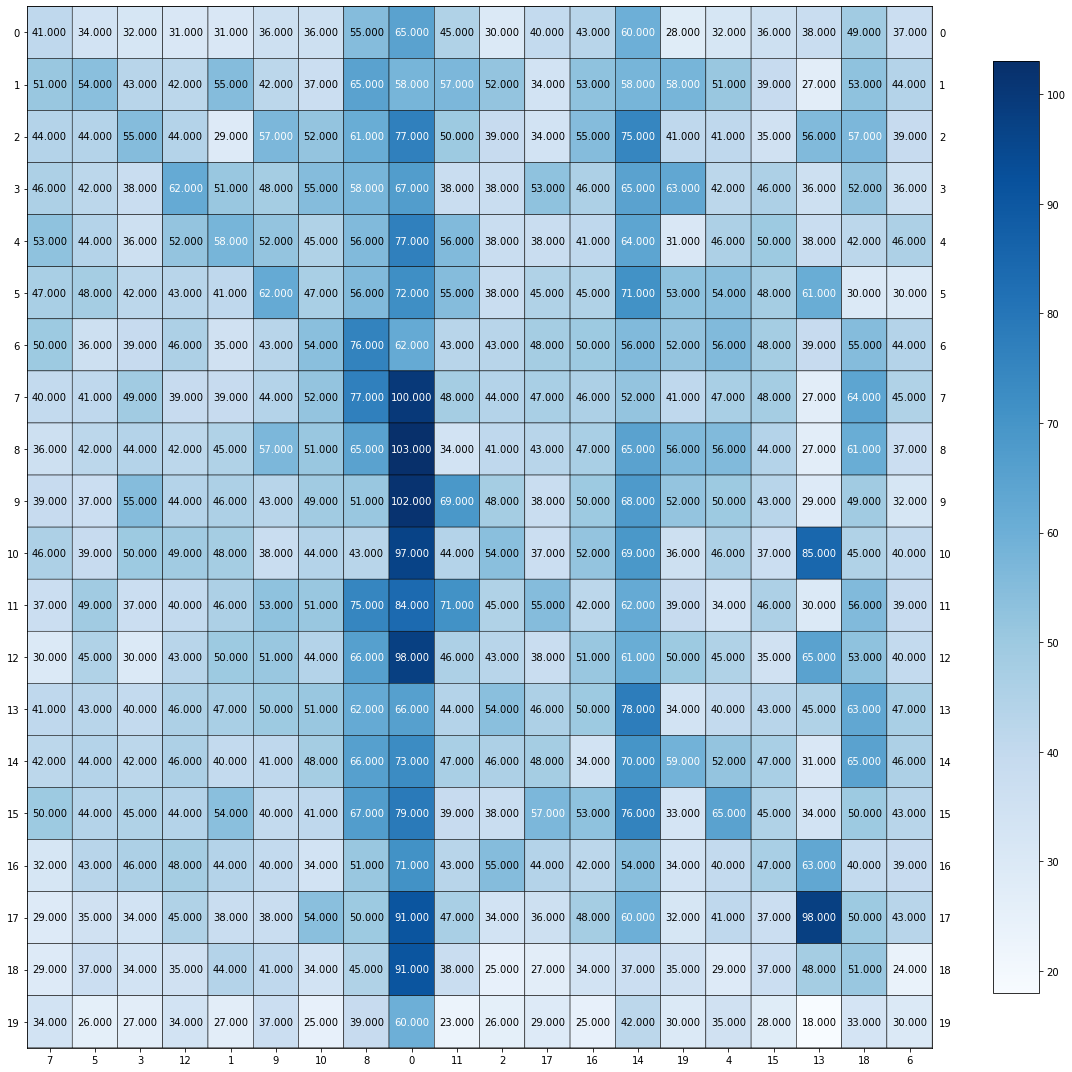

In [42]:
conf_mat = confusion_matrix(labels, UMAP_Eucl_predlabels[0])
row, colmn = linear_sum_assignment(conf_mat, maximize=True)
plot_mat(conf_mat[row[:, np.newaxis], colmn], xticklabels=colmn, yticklabels=row, size=(15,15))

#### confusion matric for #comp = 20

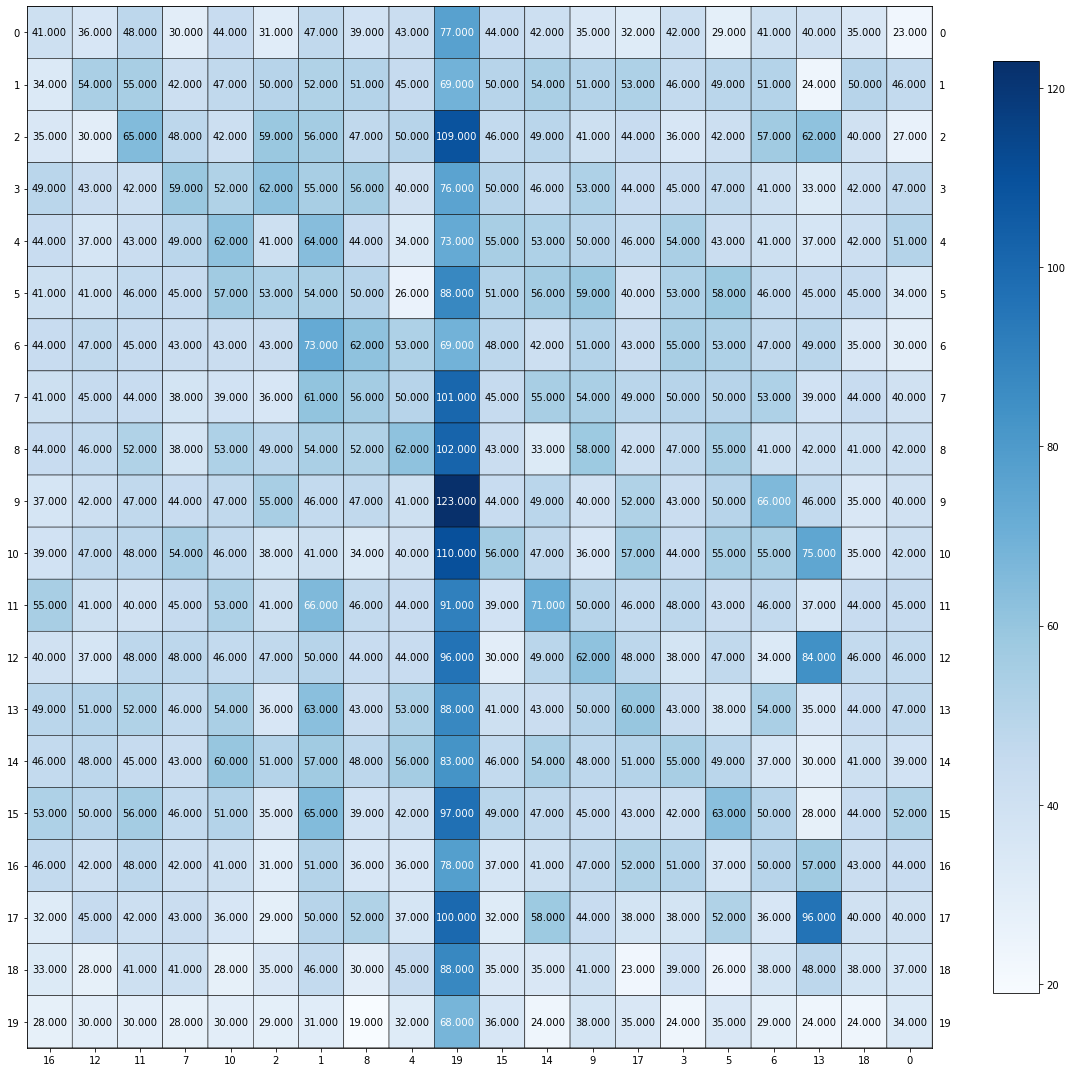

In [43]:
conf_mat = confusion_matrix(labels, UMAP_Eucl_predlabels[1])
row, colmn = linear_sum_assignment(conf_mat, maximize=True)
plot_mat(conf_mat[row[:, np.newaxis], colmn], xticklabels=colmn, yticklabels=row, size=(15,15))

#### confusion matric for #comp = 200

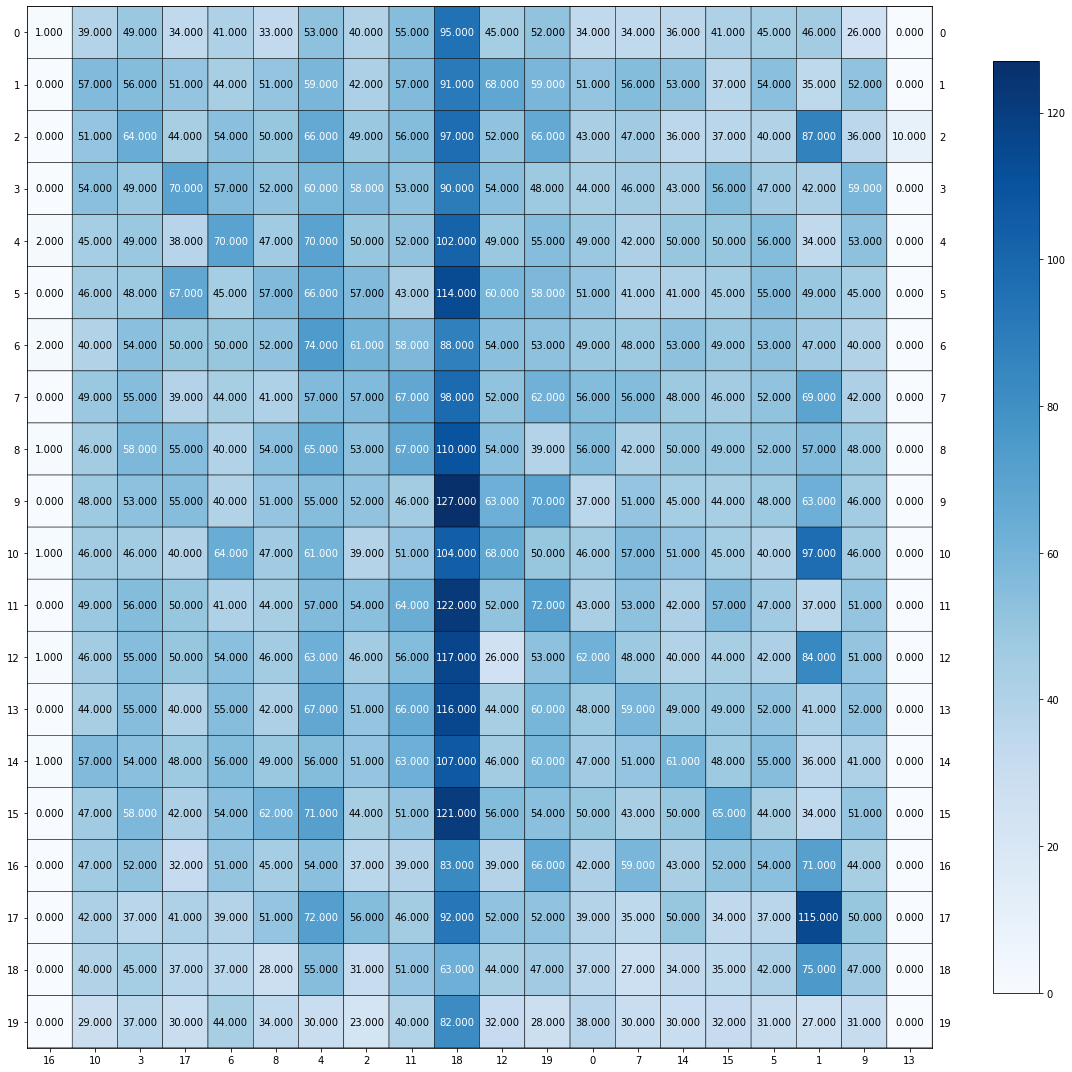

In [44]:
conf_mat = confusion_matrix(labels, UMAP_Eucl_predlabels[2])
row, colmn = linear_sum_assignment(conf_mat, maximize=True)
plot_mat(conf_mat[row[:, np.newaxis], colmn], xticklabels=colmn, yticklabels=row, size=(15,15))

### Cosine Metric

In [45]:
UMAP_Cosine_Homogeneity = []
UMAP_Cosine_Completeness = []
UMAP_Cosine_V_measure = []
UMAP_Cosine_AdjustedRandIndex = []
UMAP_Cosine_Adjusted_mutual_information_score = []
UMAP_Cosine_predlabels = []

for k in n_comps:
    umap_fit = umap.UMAP(n_components=k, random_state=0, metric='cosine')
    umap_features = umap_fit.fit_transform(tfidf_features)
    kmeans = KMeans(n_clusters=20, random_state=0, max_iter=5000, n_init=50).fit(umap_features)
    predicted_labels = kmeans.labels_
    scores = getScores(labels, predicted_labels)
    UMAP_Cosine_predlabels.append(predicted_labels)
    UMAP_Cosine_Homogeneity.append(scores['Homogeneity'])
    UMAP_Cosine_Completeness.append(scores['Completeness'])
    UMAP_Cosine_V_measure.append(scores['V_measure'])
    UMAP_Cosine_AdjustedRandIndex.append(scores['AdjustedRandIndex'])
    UMAP_Cosine_Adjusted_mutual_information_score.append(scores['Adjusted_mutual_information_score'])


In [46]:
Umap_Cosine_Scores = np.vstack([n_comps,UMAP_Cosine_Homogeneity, UMAP_Cosine_Completeness, UMAP_Cosine_V_measure, UMAP_Cosine_AdjustedRandIndex, UMAP_Cosine_Adjusted_mutual_information_score])
Umap_Cosine_Scores = Umap_Cosine_Scores.T

print("Scores for Umap with Cosine")
pd.DataFrame(Umap_Cosine_Scores, columns=['Num of Components','Homogeneity', 'Completeness', 'Vmeasure', 'ARI', 'AMIS'])

Scores for Umap with Cosine


,Num of Components,Homogeneity,Completeness,Vmeasure,ARI,AMIS
0,5.0,0.578146,0.599978,0.588860,0.451638,0.587496
1,20.0,0.573813,0.594536,0.583991,0.443968,0.582612
2,200.0,0.579453,0.600915,0.589989,0.454331,0.588630


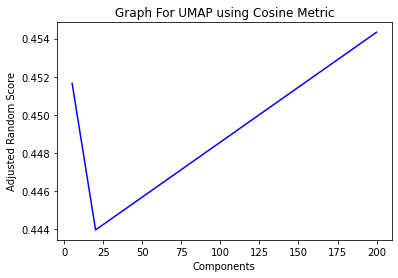

In [47]:
plt.plot(n_comps, UMAP_Cosine_AdjustedRandIndex, color='b')
  
plt.xlabel("Components")
plt.ylabel("Adjusted Random Score")
plt.title("Graph For UMAP using Cosine Metric")
  
plt.show()

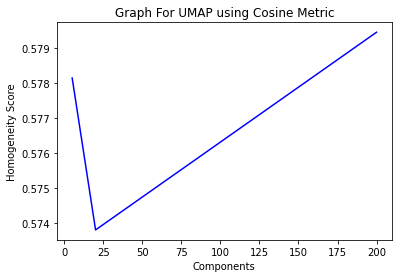

In [48]:
plt.plot(n_comps, UMAP_Cosine_Homogeneity, color='b')
  
plt.xlabel("Components")
plt.ylabel("Homogeneity Score")
plt.title("Graph For UMAP using Cosine Metric")
  
plt.show()

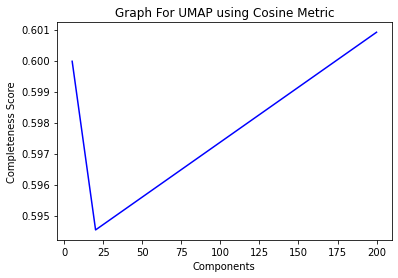

In [49]:
plt.plot(n_comps, UMAP_Cosine_Completeness, color='b')
  
plt.xlabel("Components")
plt.ylabel("Completeness Score")
plt.title("Graph For UMAP using Cosine Metric")
  
plt.show()

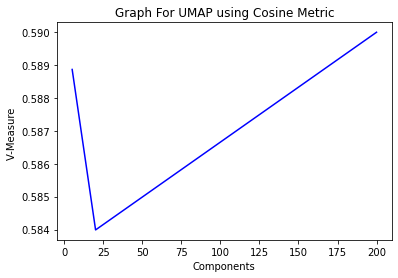

In [50]:
plt.plot(n_comps, UMAP_Cosine_V_measure, color='b')
  
plt.xlabel("Components")
plt.ylabel("V-Measure ")
plt.title("Graph For UMAP using Cosine Metric")
  
plt.show()

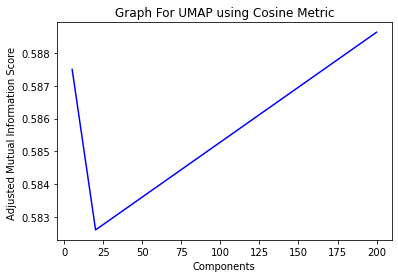

In [51]:
plt.plot(n_comps, UMAP_Cosine_Adjusted_mutual_information_score, color='b')
  
plt.xlabel("Components")
plt.ylabel("Adjusted Mutual Information Score ")
plt.title("Graph For UMAP using Cosine Metric")
  
plt.show()

#### Confusion matrix for # comp = 5

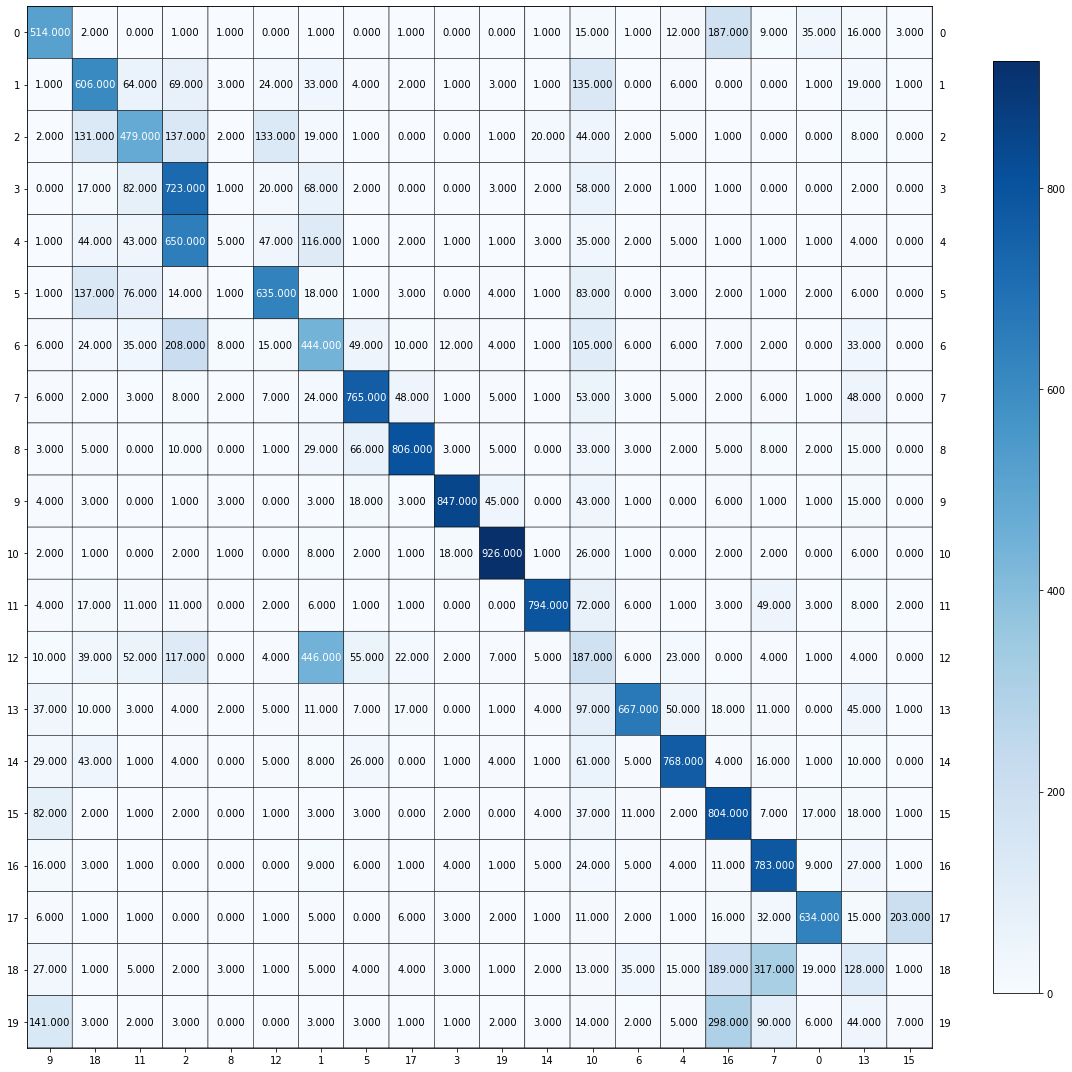

In [52]:
conf_mat = confusion_matrix(labels, UMAP_Cosine_predlabels[0])
row, colmn = linear_sum_assignment(conf_mat, maximize=True)
plot_mat(conf_mat[row[:, np.newaxis], colmn], xticklabels=colmn, yticklabels=row, size=(15,15))

#### Confusion matrix for # comp = 20

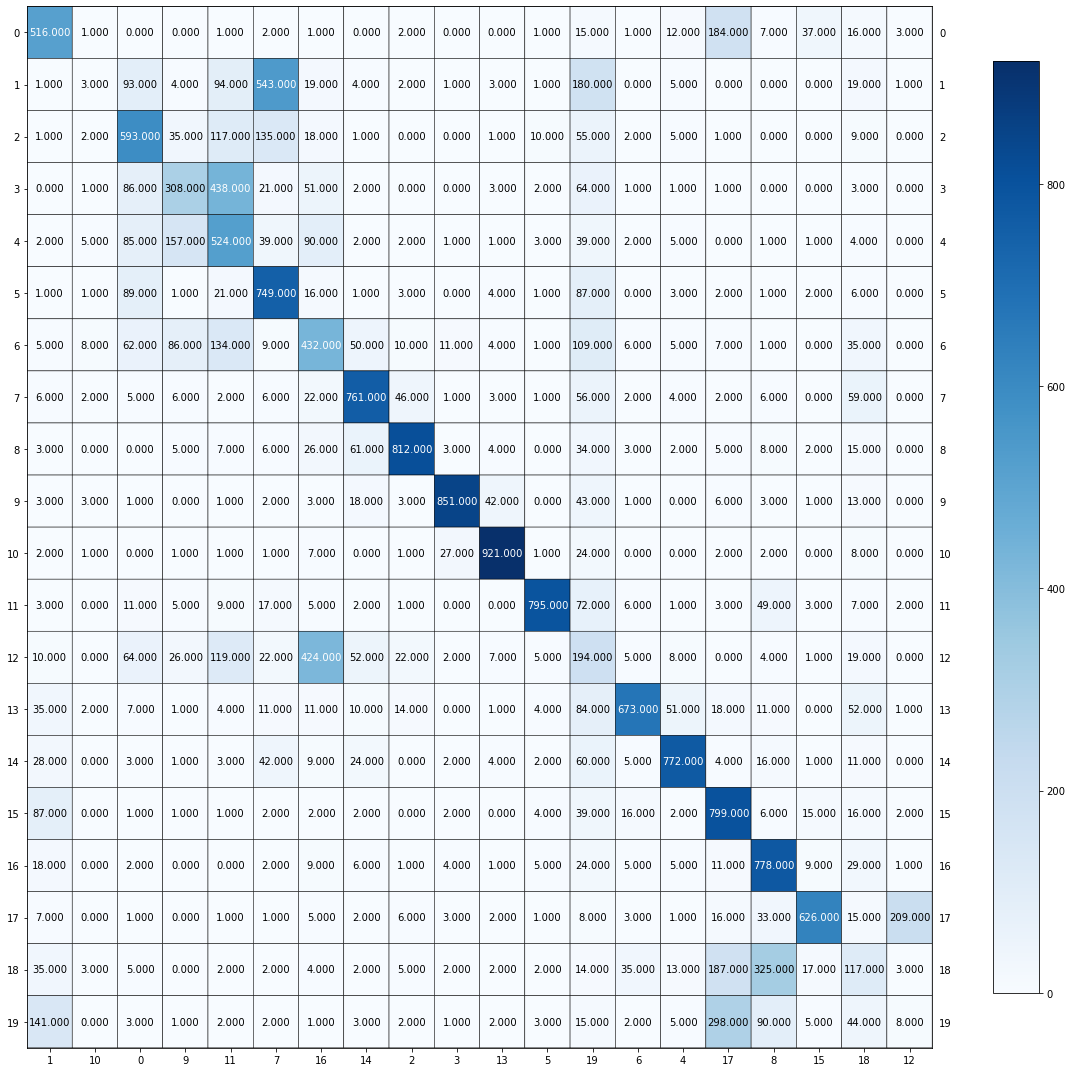

In [53]:
conf_mat = confusion_matrix(labels, UMAP_Cosine_predlabels[1])
row, colmn = linear_sum_assignment(conf_mat, maximize=True)
plot_mat(conf_mat[row[:, np.newaxis], colmn], xticklabels=colmn, yticklabels=row, size=(15,15))

#### Confusion matrix for # comp = 200

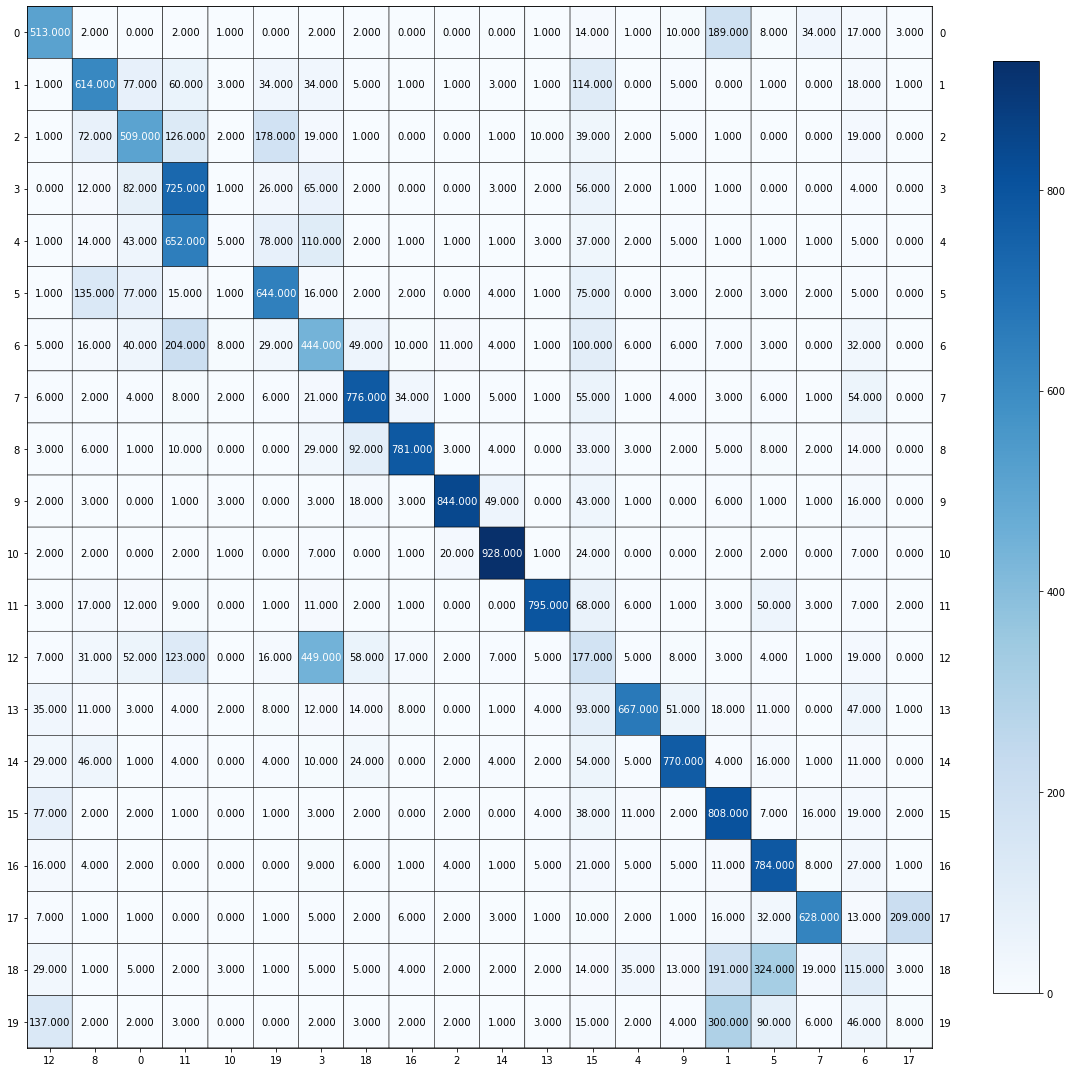

In [54]:
conf_mat = confusion_matrix(labels, UMAP_Cosine_predlabels[2])
row, colmn = linear_sum_assignment(conf_mat, maximize=True)
plot_mat(conf_mat[row[:, np.newaxis], colmn], xticklabels=colmn, yticklabels=row, size=(15,15))

### Agglomerative Clustering

#### Ward Agglomerative

In [31]:
ncomps = [5, 20, 50, 100, 200]
num_clusters = 20
Agglomerative_Ward_Homogeneity = []
Agglomerative_Ward_Completeness = []
Agglomerative_Ward_V_measure = []
Agglomerative_Ward_AdjustedRandIndex = []
Agglomerative_Ward_Adjusted_mutual_information_score = []
Agglomerative_Ward_predlabels = []

for comps in ncomps:
    umap_ext = umap.UMAP(n_components=comps, metric='cosine')
    umap_features = umap_ext.fit_transform(tfidf_features)
    Agglomerative_Clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward').fit(umap_features)
    
    predictedLabels = Agglomerative_Clustering.labels_
    scores = getScores(labels, predictedLabels)
    
    Agglomerative_Ward_predlabels.append(predictedLabels)
    Agglomerative_Ward_Homogeneity.append(scores['Homogeneity'])
    Agglomerative_Ward_Completeness.append(scores['Completeness'])
    Agglomerative_Ward_V_measure.append(scores['V_measure'])
    Agglomerative_Ward_AdjustedRandIndex.append(scores['AdjustedRandIndex'])
    Agglomerative_Ward_Adjusted_mutual_information_score.append(scores['Adjusted_mutual_information_score'])

In [32]:
AggScores = np.vstack([ncomps,Agglomerative_Ward_Homogeneity, Agglomerative_Ward_Completeness, Agglomerative_Ward_V_measure, Agglomerative_Ward_AdjustedRandIndex, Agglomerative_Ward_Adjusted_mutual_information_score])
AggScores = AggScores.T

print("Scores for Agglomerative Clustering for ward linkage")
pd.DataFrame(AggScores, columns=['Num of Components','Homogeneity', 'Completeness', 'Vmeasure', 'ARI', 'AMIS'])

Scores for Agglomerative Clustering for ward linkage


,Num of Components,Homogeneity,Completeness,Vmeasure,ARI,AMIS
0,5.0,0.555949,0.580151,0.567792,0.410522,0.566354
1,20.0,0.555371,0.590477,0.572386,0.416165,0.570950
2,50.0,0.560211,0.605615,0.582029,0.413929,0.580613
3,100.0,0.541147,0.583006,0.561297,0.401055,0.559814
4,200.0,0.554767,0.578442,0.566357,0.407881,0.564926


#### Agglomerative with single linkage 

In [55]:
ncomps = [5, 20, 50, 100, 200]
num_clusters = 20
Agglomerative_Single_Homogeneity = []
Agglomerative_Single_Completeness = []
Agglomerative_Single_V_measure = []
Agglomerative_Single_AdjustedRandIndex = []
Agglomerative_Single_Adjusted_mutual_information_score = []
Agglomerative_Single_predlabels = []

for comps in ncomps:
    umap_ext = umap.UMAP(n_components=comps, metric='cosine')
    umap_features = umap_ext.fit_transform(tfidf_features)
    Agglomerative_Clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage='single').fit(umap_features)
    
    predictedLabels = Agglomerative_Clustering.labels_
    scores = getScores(labels, predictedLabels)
    
    Agglomerative_Single_predlabels.append(predictedLabels)
    Agglomerative_Single_Homogeneity.append(scores['Homogeneity'])
    Agglomerative_Single_Completeness.append(scores['Completeness'])
    Agglomerative_Single_V_measure.append(scores['V_measure'])
    Agglomerative_Single_AdjustedRandIndex.append(scores['AdjustedRandIndex'])
    Agglomerative_Single_Adjusted_mutual_information_score.append(scores['Adjusted_mutual_information_score'])

In [56]:
AggScores = np.vstack([ncomps,Agglomerative_Single_Homogeneity, Agglomerative_Single_Completeness, Agglomerative_Single_V_measure, Agglomerative_Single_AdjustedRandIndex, Agglomerative_Single_Adjusted_mutual_information_score])
AggScores = AggScores.T

print("Scores for Agglomerative Clustering for Single linkage")
pd.DataFrame(AggScores, columns=['Num of Components','Homogeneity', 'Completeness', 'Vmeasure', 'ARI', 'AMIS'])

Scores for Agglomerative Clustering for Single linkage


,Num of Components,Homogeneity,Completeness,Vmeasure,ARI,AMIS
0,5.0,0.097752,0.724632,0.172266,0.019885,0.168658
1,20.0,0.019735,0.356318,0.037398,0.000585,0.032366
2,50.0,0.007081,0.284159,0.013817,0.000011,0.009153
3,100.0,0.017823,0.392942,0.034100,0.000471,0.029320
4,200.0,0.008757,0.291097,0.017003,-0.000028,0.012261


In [16]:
def get_UMAP(components, features):
    umap_fit = umap.UMAP(n_components=components, metric='cosine')
    umap_features = umap_fit.fit_transform(features)
    return umap_features

UMAP_Dict = {}
n_components = [5,20,200]
for components in n_components:
    UMAP_Dict[components] = get_UMAP(components, tfidf_features)


### HDBSCAN

In [24]:
min_cluster_sizes = [20,100, 200]
min_samples = [20,100, 200]
epsilon_values = [0.5, 0.8, 5]

best_HDBS_Score = -10000

best_HDBS_SCAN = []
best_HDBS_Scores = {}
best_HDBS_Labels = []

for components in n_components:
    
    umap_feat = UMAP_Dict[components]
    
    for eps in epsilon_values:
        
        for min_sample in min_samples:
            
            for min_cluster_size in min_cluster_sizes:
                
                HDBS = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_sample, cluster_selection_epsilon=eps)
                
                HDBS.fit(umap_feat)
                
                HDBS_Score = getScores(labels, HDBS.labels_)
                
                avg_HDBS_Score = (HDBS_Score["Homogeneity"] + HDBS_Score["Completeness"] + HDBS_Score["V_measure"] + HDBS_Score["AdjustedRandIndex"] + HDBS_Score["Adjusted_mutual_information_score"]) / 5
                
                if avg_HDBS_Score > best_HDBS_Score:
                    best_HDBS_Score = avg_HDBS_Score
                    best_HDBS_SCAN = HDBS
                    best_HDBS_Scores = HDBS_Score
                    best_HDBS_Labels = HDBS.labels_

In [25]:
best_HDBS_Scores

{'Homogeneity': 0.4288172302386655,
 'Completeness': 0.6311628166704663,
 'V_measure': 0.5106765767213844,
 'AdjustedRandIndex': 0.22279185537738072,
 'Adjusted_mutual_information_score': 0.5096871111338204}

In [26]:
print(best_HDBS_SCAN)

HDBSCAN(cluster_selection_epsilon=0.5, min_cluster_size=20, min_samples=100)


#### Contingency Matrix for best HDBS_SCAN

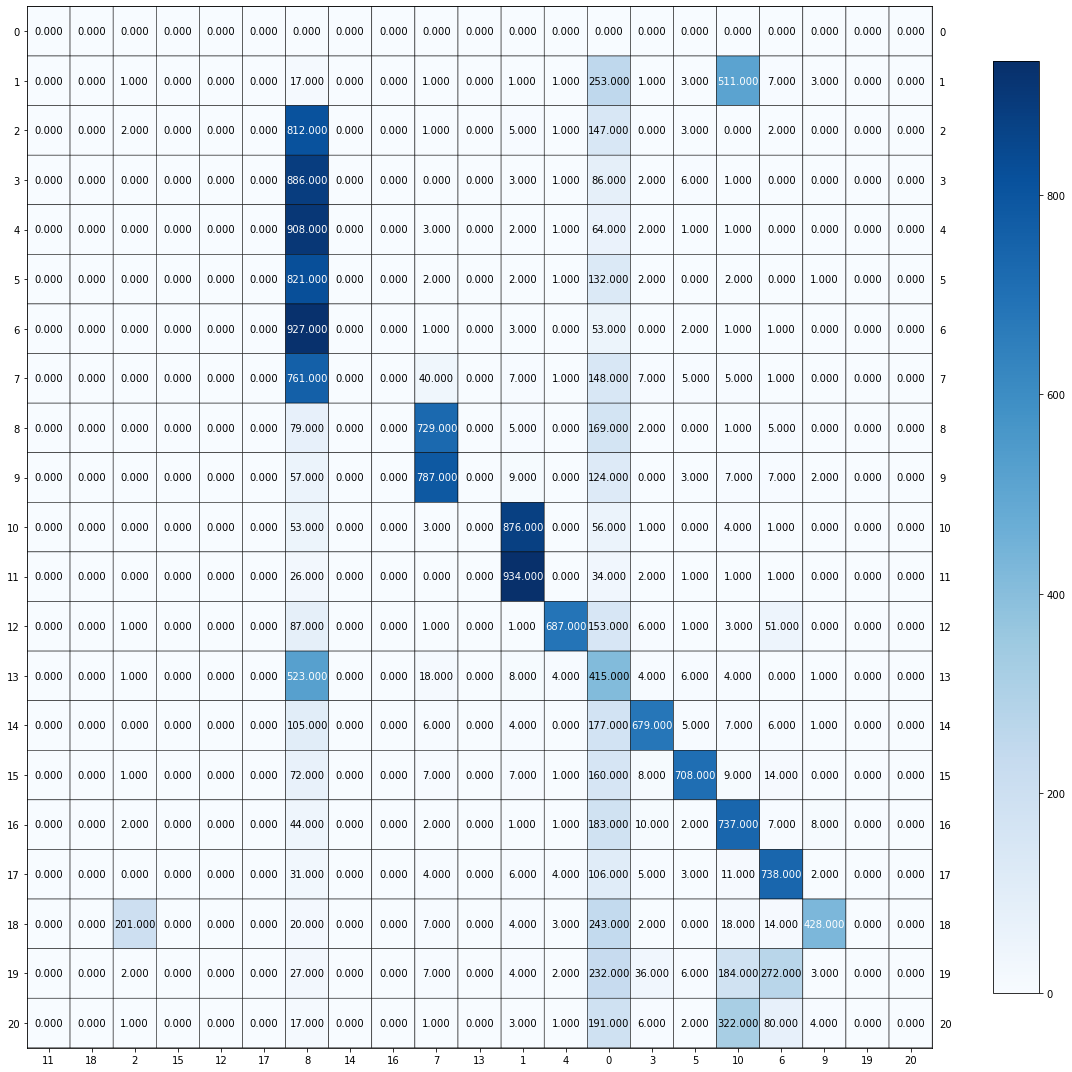

In [28]:
conf_mat_HDBS = confusion_matrix(labels, best_HDBS_Labels)
rows, colmns = linear_sum_assignment(conf_mat_HDBS, maximize=True)
plot_mat(conf_mat_HDBS[rows[:, np.newaxis], colmns], xticklabels=colmns, yticklabels=rows, size=(15,15))

In [17]:
SVD_Dict = {}
NMF_Dict = {}
n_components = [5, 20, 200]
for components in n_components:
    svd = getSVD(components, tfidf_features)
    SVD_Dict[components] = svd.transform(tfidf_features)
    nmf = getNMF(components, tfidf_features)
    NMF_Dict[components] = nmf.transform(tfidf_features)


/Users/diplavsrivastava/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [18]:
red_DICT = {
    'SVD': SVD_Dict,
    'NMF': NMF_Dict,
    'UMAP': UMAP_Dict
}

In [32]:
# paramters
reduction_method = ['None', 'SVD', 'NMF', 'UMAP']
kmeans_clusters = [10, 20, 50]
n_components = [5, 20, 200]

best_ARI_KM = 0
best_Red_KM = 'None'
best_k_KM = 0
best_KMEANS = []
best_Kmeans_Scores = []
best_Comp_KM = 5

for reduction in reduction_method:
    if reduction == 'None':
        for k in kmeans_clusters:
            kmean = KMeans(n_clusters=k, random_state=0, max_iter=3000, n_init=50).fit(tfidf_features)
            predicted_Labels = kmean.labels_
            curr_scores = getScores(labels, predicted_Labels)
            
            if curr_scores['AdjustedRandIndex'] > best_ARI_KM:
                best_ARI_KM = curr_scores['AdjustedRandIndex']
                best_Red_KM = 'None'
                best_Kmeans_Scores = curr_scores
                best_k_KM = k
                best_KMEANS = kmean
                best_Comp_KM = 'All'
    else:
        for components in n_components:
            features = red_DICT[reduction][components]
            for k in kmeans_clusters:
                kmean = KMeans(n_clusters=k, random_state=0, max_iter=3000, n_init=50).fit(features)
                predicted_Labels = kmean.labels_
                curr_scores = getScores(labels, predicted_Labels)

                if curr_scores['AdjustedRandIndex'] > best_ARI_KM:
                    best_ARI_KM = curr_scores['AdjustedRandIndex']
                    best_Red_KM = reduction
                    best_Kmeans_Scores = curr_scores
                    best_k_KM = k
                    best_KMEANS = kmean
                    best_Comp_KM = components

In [33]:
print("Best KMeans Scores: " , best_Kmeans_Scores)
print("Best Number of Clusters: ", best_k_KM)
print("Best Reduction Method: ", best_Red_KM)
print("Best Components for the reduction method: ", best_Comp_KM)
print("Best Clusterer: ", best_KMEANS)

Best KMeans Scores:  {'Homogeneity': 0.5757133966531727, 'Completeness': 0.6034441953304674, 'V_measure': 0.5892527169331307, 'AdjustedRandIndex': 0.4460629307885138, 'Adjusted_mutual_information_score': 0.5878930714729503}
Best Number of Clusters:  20
Best Reduction Method:  UMAP
Best Components for the reduction method:  5
Best Clusterer:  KMeans(max_iter=3000, n_clusters=20, n_init=50, random_state=0)


In [22]:
#parameter
reduction_method = ['None', 'SVD', 'NMF', 'UMAP']
clusters_Agglo = [20]
n_components = [5, 20, 200]

best_ARI_Agglo = 0
best_Red_Agglo = 'None'
best_k_Agglo = 0
best_AGGLO = []
best_Agglo_Scores = []
best_Comp_Agglo = 5


for reduction in reduction_method:
    if reduction == 'None':
        for k in clusters_Agglo:
            Agglo_Clustering = AgglomerativeClustering(n_clusters=k, linkage='ward').fit(tfidf_features.toarray())
            predicted_Labels = Agglo_Clustering.labels_
            curr_scores = getScores(labels, predicted_Labels)
            
            if curr_scores['AdjustedRandIndex'] > best_ARI_Agglo:
                best_ARI_Agglo = curr_scores['AdjustedRandIndex']
                best_Red_Agglo = 'None'
                best_Agglo_Scores = curr_scores
                best_k_Agglo = k
                best_AGGLO = Agglo_Clustering
                best_Comp_Agglo = 'All'
    else:
        for components in n_components:
            features = red_DICT[reduction][components]
            for k in clusters_Agglo:
                Agglo_Clustering = AgglomerativeClustering(n_clusters=k, linkage='ward').fit(features)
                predicted_Labels = Agglo_Clustering.labels_
                curr_scores = getScores(labels, predicted_Labels)

                if curr_scores['AdjustedRandIndex'] > best_ARI_Agglo:
                    best_ARI_Agglo = curr_scores['AdjustedRandIndex']
                    best_Red_Agglo = reduction
                    best_Agglo_Scores = curr_scores
                    best_k_Agglo = k
                    best_AGGLO = Agglo_Clustering
                    best_Comp_Agglo = components

In [23]:
print("Best Agglomerative Scores: " , best_Agglo_Scores)
print("Best Number of Clusters: ", best_k_Agglo)
print("Best Reduction Method: ", best_Red_Agglo)
print("Best Components for the reduction method: ", best_Comp_Agglo)
print("Best Agglomerative Clusterer: ", best_AGGLO)

Best Agglomerative Scores:  {'Homogeneity': 0.5592790855076187, 'Completeness': 0.5940080370036646, 'V_measure': 0.5761206645508782, 'AdjustedRandIndex': 0.4270833817429984, 'Adjusted_mutual_information_score': 0.5746985808250807}
Best Number of Clusters:  20
Best Reduction Method:  UMAP
Best Components for the reduction method:  5
Best Agglomerative Clusterer:  AgglomerativeClustering(n_clusters=20)


In [20]:
#parameter
reduction_method = ['SVD', 'NMF', 'UMAP']
clusters_HDBS = [100, 200]
n_components = [5, 20, 200]


best_ARI_HDBS = 0
best_Red_HDBS = 'SVD'
best_k_HDBS = 0
best_HDBS = []
best_HDBS_Scores = []
best_Comp_HDBS = 5


for reduction in reduction_method:
    for components in n_components:
        features = red_DICT[reduction][components]
        for k in clusters_HDBS:
            
            HDBS = hdbscan.HDBSCAN(cluster_selection_epsilon=0.5, min_cluster_size=k, min_samples=100)
            HDBS.fit(features)
            predicted_Labels = HDBS.labels_
            curr_scores = getScores(labels, predicted_Labels)

            if curr_scores['AdjustedRandIndex'] > best_ARI_HDBS:
                best_ARI_HDBS = curr_scores['AdjustedRandIndex']
                best_Red_HDBS = reduction
                best_HDBS_Scores = curr_scores
                best_k_HDBS = k
                best_HDBS = HDBS
                best_Comp_HDBS = components

In [21]:
print("Best HDBSCAN Scores: " , best_HDBS_Scores)
print("Best min clusters: ", best_k_HDBS)
print("Best Reduction Method: ", best_Red_HDBS)
print("Best Components for the reduction method: ", best_Comp_HDBS)
print("Best HDBSCAN: ", best_HDBS)

Best HDBSCAN Scores:  {'Homogeneity': 0.43227904314177473, 'Completeness': 0.6385902396914952, 'V_measure': 0.5155609226985286, 'AdjustedRandIndex': 0.22472241227952833, 'Adjusted_mutual_information_score': 0.5145797829160398}
Best min clusters:  200
Best Reduction Method:  UMAP
Best Components for the reduction method:  5
Best HDBSCAN:  HDBSCAN(cluster_selection_epsilon=0.5, min_cluster_size=200, min_samples=100)


### Q18

#### Approach 1

In [24]:
umap_mod = umap.UMAP(n_components=50)
UMAP_features = umap_mod.fit_transform(tfidf_features)

svd_mod = getSVD(50, tfidf_features)
svd_features = svd_mod.transform(tfidf_features)

nmf_mod = getNMF(50, tfidf_features)
nmf_features = nmf_mod.transform(tfidf_features)

cross_features = np.multiply(UMAP_features, svd_features)

clusters = KMeans(n_clusters=20, random_state=0, max_iter=3000, n_init=50).fit(cross_features)
clusters_Labels = clusters.labels_

/Users/diplavsrivastava/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [25]:
getScores(labels, clusters_Labels)

{'Homogeneity': 0.26263694661814285,
 'Completeness': 0.3390506603315467,
 'V_measure': 0.29599157153917666,
 'AdjustedRandIndex': 0.05462479382843152,
 'Adjusted_mutual_information_score': 0.29341090858213137}

#### Approach 2

In [26]:
# data with header and footer 
data = datasets.fetch_20newsgroups(subset='all')
fullData = data.data
labelNames = np.array(data.target_names)
fullDataLabels = np.array(data.target)
stringLabels = np.array([labelNames[label] for label in fullDataLabels])

In [27]:
pipe = Pipeline([
    ('count', CountVectorizer(preprocessor=preprocess, stop_words='english', min_df=3)),
    ('tfidf', TfidfTransformer(smooth_idf=True, use_idf=True))
]).fit(fullData)

newsData3df = pipe.transform(fullData)

In [28]:
pipe = Pipeline([
    ('count', CountVectorizer(preprocessor=preprocess, stop_words='english', min_df=5)),
    ('tfidf', TfidfTransformer(smooth_idf=True, use_idf=True))
]).fit(fullData)

newsData5df = pipe.transform(fullData)

In [29]:
umap_mod = umap.UMAP(n_components=100, random_state=42)
UMAPFeat3 = umap_mod.fit_transform(newsData3df)

svdmod = getSVD(100, newsData3df)
svdFeat3 = svdmod.transform(newsData3df)

umap_mod = umap.UMAP(n_components=100, random_state=42)
UMAPFeat5 = umap_mod.fit_transform(newsData5df)

svdmod = getSVD(100, newsData5df)
svdFeat5 = svdmod.transform(newsData5df)


In [30]:
clusterer = KMeans(n_clusters=20, random_state=0, max_iter=5000, n_init=50).fit(UMAPFeat3)
clustLabs = clusterer.labels_
getScores(labels, clustLabs)

{'Homogeneity': 0.5377330454432618,
 'Completeness': 0.5701005510124901,
 'V_measure': 0.553443958525178,
 'AdjustedRandIndex': 0.43210015033519894,
 'Adjusted_mutual_information_score': 0.5519450599961752}

In [31]:
clusterer = KMeans(n_clusters=20, random_state=0, max_iter=5000, n_init=50).fit(svdFeat3)
clustLabs = clusterer.labels_
getScores(labels, clustLabs)


{'Homogeneity': 0.3180156339085947,
 'Completeness': 0.40555968040622326,
 'V_measure': 0.3564917605689272,
 'AdjustedRandIndex': 0.10504304304624516,
 'Adjusted_mutual_information_score': 0.354134206043779}

In [32]:
clusterer = KMeans(n_clusters=20, random_state=0, max_iter=5000, n_init=50).fit(UMAPFeat5)
clustLabs = clusterer.labels_
getScores(labels, clustLabs)


{'Homogeneity': 0.5325344228011074,
 'Completeness': 0.5512554917732764,
 'V_measure': 0.541733266161104,
 'AdjustedRandIndex': 0.4347861276578972,
 'Adjusted_mutual_information_score': 0.5402261154056546}

In [33]:
clusterer = KMeans(n_clusters=20, random_state=0, max_iter=5000, n_init=50).fit(svdFeat5)
clustLabs = clusterer.labels_
getScores(labels, clustLabs)

{'Homogeneity': 0.35316781749278253,
 'Completeness': 0.44197398029529644,
 'V_measure': 0.39261169880315927,
 'AdjustedRandIndex': 0.12325051840957109,
 'Adjusted_mutual_information_score': 0.39039800608132064}